# H2-stretch
In this notebook, the previous coded implementation of RHF and UHF will be visualised using $H_{2}$ as test-molecule.

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from pyscf import gto, scf
import scipy

In [135]:
MAXITER = 100
E_conv = 1.0e-6

In [136]:
def RHF(mol):
    S = mol.intor('int1e_ovlp')
    T = mol.intor('int1e_kin')
    V = mol.intor('int1e_nuc')
    H_core = T + V
    eri = mol.intor('int2e')
    # ==> SCF Iterations <==
    # Pre-iteration energy declarations
    SCF_E_RHF = 0.0
    E_old = 0.0

    ndocc = mol.nelec[0]
    # Initial guess starts without C, so just the hamiltonian
    eps, C = scipy.linalg.eigh(H_core, S)
    C_occ = C[:, :ndocc]
    D = np.einsum('pi,qi->pq', C_occ, C_occ, optimize=True)
    # Begin Iterations
    for scf_iter in range(1, MAXITER + 1):
        # Build Fock matrix: F = H + 2J - K
        J = np.einsum('pqrs,rs->pq', eri, D, optimize=True)
        K = np.einsum('prqs,rs->pq', eri, D, optimize=True)
        F = 2*J - K + H_core   

        # Compute RHF energy: BO nuclear energy and RHF electronc energy
        enuc = mol.get_enuc()
        E_RHF_el_matrix = (F+ H_core) * D
        E_RHF_el = np.sum(E_RHF_el_matrix)       
        SCF_E_RHF = enuc + E_RHF_el

        # SCF Converged?
        if (abs(SCF_E_RHF - E_old) < E_conv):
            break
        E_old = SCF_E_RHF
        
        # Compute new orbital guess
        eps, C = scipy.linalg.eigh(F,S)
        C_occ = C[:, :ndocc]
        D = np.einsum('pi,qi->pq', C_occ, C_occ, optimize=True)
        
        # MAXITER exceeded?
        if (scf_iter == MAXITER):
            raise Exception("Maximum number of SCF iterations exceeded.")
    return SCF_E_RHF



In [137]:
def UHF(mol):
    S = mol.intor('int1e_ovlp')
    T = mol.intor('int1e_kin')
    V = mol.intor('int1e_nuc')
    H_core = T + V
    eri = mol.intor('int2e')
    # ==> SCF Iterations <==
    # Pre-iteration energy declarations
    SCF_E_UHF = 0.0
    E_old = 0.0

    eps, C = scipy.linalg.eigh(H_core, S)
    n_alpha = mol.nelec[0]
    n_beta = mol.nelec[1]

    Calpha = C[:, :n_alpha]
    Cbeta = C.conj().T[:, :n_beta]


    D_alpha = np.einsum('pi,qi->pq', Calpha, Calpha, optimize=True)
    D_beta = np.einsum('pi,qi->pq', Cbeta, Cbeta, optimize=True)
    D = np.einsum('pi,qi->pq', C[:,:max(n_alpha, n_beta)], C[:,:max(n_alpha, n_beta)], optimize=True)

    # Begin Iterations
    for scf_iter in range(1, MAXITER + 1):
        # Build Fock matrices: F_alpha = H + (J - K)_alpha + J_beta and F_beta = H + (J - K)_beta + J_alpha
        # The same procedure will be used but there will be a separation between the F_alpha and F_beta
        J_alpha = np.einsum('pqrs,rs->pq', eri, D_alpha, optimize=True)
        K_alpha = np.einsum('prqs,rs->pq', eri, D_alpha, optimize=True)
        J_beta = np.einsum('pqrs,rs->pq', eri, D_beta, optimize=True)
        K_beta = np.einsum('prqs,rs->pq', eri, D_beta, optimize=True)


        F_alpha = (J_alpha - K_alpha  + J_beta) + H_core
        F_beta = (J_alpha + J_beta - K_beta) + H_core
        F = H_core + (J_alpha - K_alpha) + (J_beta - K_beta)
        # Compute RHF energy: BO nuclear energy and RHF electronc energy
        enuc = mol.get_enuc() # The BO is not different from RHF
        #E_UHF_el_matrix_alpha = ( H_core + F_alpha) * D_alpha
        #E_UHF_el_matrix_beta = (F_beta + H_core) * D_beta
        E_UHF_matrix = 0.5 * (D_alpha * (F_alpha + H_core) +  D_beta * (F_beta + H_core))
        #E_UHF_el = np.sum(E_UHF_el_matrix_alpha) + np.sum(E_UHF_el_matrix_beta)
        E_UHF_el = np.sum(E_UHF_matrix)
        SCF_E_UHF = enuc + E_UHF_el

        # SCF Converged?
        if (abs(SCF_E_UHF - E_old) < E_conv):
            break
        E_old = SCF_E_UHF
        
        # Compute new orbital guess
        eps, C1 = scipy.linalg.eigh(F_alpha,S)
        eps1 , C2 = scipy.linalg.eigh(F_beta,S)

        Calpha = C1[:, :n_alpha]
        Cbeta = C2[:, : n_beta]

        #D = np.einsum('pi,qi->pq', C[:,:max(n_alpha, n_beta)], C[:,:max(n_alpha, n_beta)], optimize=True)
        D_alpha = np.einsum('pi,qi->pq', Calpha, Calpha, optimize=True)
        D_beta = np.einsum('pi,qi->pq', Cbeta, Cbeta, optimize=True)
        #D = np.einsum('pi,qi->pq', C[:,:(n_alpha + n_beta)], C[:,:(n_alpha + n_beta)], optimize=True)

        # MAXITER exceeded?
        if (scf_iter == MAXITER):
            print(SCF_E_UHF)
            raise Exception("Maximum number of SCF iterations exceeded.")

    return SCF_E_UHF

In [142]:
distance_list = []
energy_RHF_list = []
energy_UHF_list = []

for distance in np.arange(0.2,3, 0.01):
    #distance *= 0.1
    mol = gto.M(atom = f'H 0.0 0.0 0.0; H {distance:.2f} 0.0 0.0')
    energy_UHF_list.append(UHF(mol))
    energy_RHF_list.append(RHF(mol))
    distance_list.append(distance)


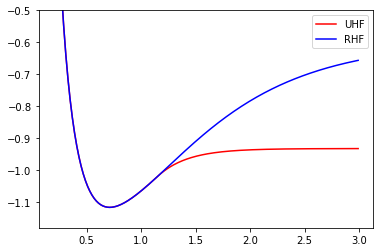

In [144]:
plt.plot(distance_list, energy_UHF_list, 'r', label = 'UHF')
plt.plot(distance_list, energy_RHF_list, 'b', label = 'RHF')

plt.ylim(top=-0.5)
plt.legend()
plt.show()